# Actividad 2: Descripción de datos
#### Gabriel Missael Barco

Usaremos los datos del archivo "prison_report.xlsx", el cual contiene información sobre las personas encarceladas por region, país y año, desde el 2003 hasta el 2017. Esta tabla nos proporciona el numero de personas encarceladas ese año (N), así como un el "rate" que es el promedio de personas encarceladas por cada 100,000 personas ((N/población del pais)*100000).

In [3]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
#Leemos el archivo y vemos la forma que tiene
datos = pd.read_excel("../datos/prison_report.xlsx")
datos = datos.sort_values(by = "Countries")
paises = pd.read_csv("../datos/paises.csv")
paises = paises.rename(columns = {"name":"countries"})

### Preguntas
En este trabajo trataremos de responder (mediante graficas y tablas) a las siguientes preguntas:

1. ¿Cual ha sido el incremento del numero personas encarcerladas a nivel mundial?
2. ¿Cual ha sido el incremento del promedio de personas encarceladas a nivel mundial?
3. En estos datos, ¿Cual es el tamaño de la muestra de poblacion abarcada? 
4. ¿Tiene alguna relacion la zona geografica con el numero de personas encarceladas?
5. ¿Cómo se posiciona México en este aspecto respecto a los demas paises?
6. ¿En que subregion se encuentra el mayor promedio de personas en situación de carcel?


#### Pregunta 1 y 2
1. ¿Cual ha sido el incremento del numero personas encarcerladas a nivel mundial en el tiempo?
2. ¿Cual ha sido el incremento del promedio de personas encarceladas a nivel mundial en el tiempo?

Estas dos preguntas son muy similares, y el proposito de hacerlas es darnos cuenta de que no es tan importante el numero de personas encarceldas, si no mas bien esto debe estar promediado con la poblacion. Es obvio pensar que a mas población, mas personas encarceladas, por lo que este dato por si solo no nos proporciona mucha información. En las siguientes gráficas se observa la respuesta a estas dos preguntas, respectivamente.
Para obtener el promedio, primeramente obtenemos la poblacion mundial de muestra de ese año (que no siempre es la misma), esto es posible ya que tenemos el numero de personas encarceladas y el promedio por 100,000 habitantes de cada país en ese año.

Poblacion en un país en x año = (numero de encarcelados/rate)*100000

In [5]:
#Primero ordenamos los indices en funcion del año
promedio = datos.sort_values(by = "Year").copy()

x_count = np.zeros(15)
x_rate = np.zeros(15)
poblacion = np.zeros(15)
year = np.linspace(2003, 2017, 15)


for i in range(15):
    aux = 0
    x_count[i] = promedio[promedio.Year == 2003+i].sum()["Count"]
    for j in promedio[promedio.Year == 2003+i]["Count"]:
        if promedio[promedio.Year == 2003+i]["Rate"].iloc[aux] !=0:
            poblacion[i] += j/promedio[promedio.Year == 2003+i]["Rate"].iloc[aux]*100000
        aux += 1
    #print(poblacion[i], x_count[i])
    x_rate[i] = (x_count[i]/poblacion[i])*100000

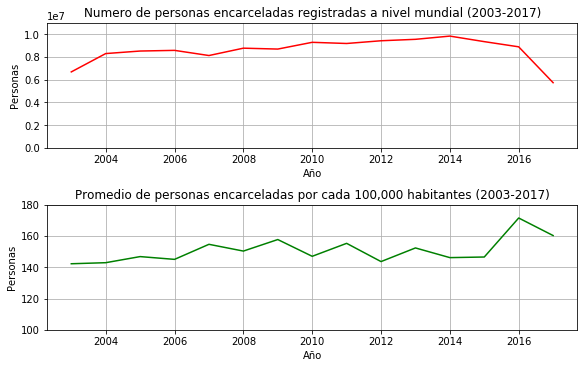

In [6]:
fig, (count, rate) = plt.subplots(2, 1,figsize=(8, 5), constrained_layout=True)

count.plot(year, x_count, color = "red")
count.set_title("Numero de personas encarceladas registradas a nivel mundial (2003-2017)")
count.grid()
count.set_ylim(0, 11000000)
count.set_xlabel("Año")
count.set_ylabel("Personas")
rate.plot(year, x_rate, color = "green")
rate.set_title("Promedio de personas encarceladas por cada 100,000 habitantes (2003-2017)")
rate.grid()
rate.set_ylim(100, 180)
rate.set_xlabel("Año")
rate.set_ylabel("Personas")

plt.savefig("Graficas_actividad2/Promedio_y_Conteo_Mundial.png")

#### Pregunta 3
3. En estos datos, ¿Cual es el tamaño de la muestra de poblacion abarcada cada año? 

En esta base de datos no se encuentra el total global por año, si no mas bien parte de ella, una muestra. Es importante considerar y conocer el tamaño de la muestra respecto a la población real de un experimento o valor.
Estimados de población mundial total por año obtenidos de: https://datos.bancomundial.org/indicador/SP.POP.TOTL?end=2017&start=2003&view=chart

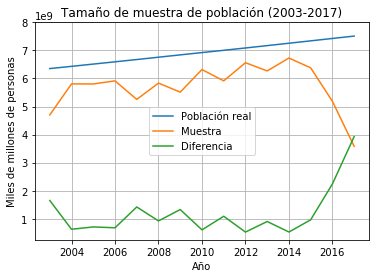

In [7]:
poblacion_real = [6353000000, 6432000000, 6513000000, 6594000000, 
                  6675000000, 6758000000, 6841000000, 6923000000,
                  7004000000, 7087000000, 7171000000, 7256000000, 
                  7341000000, 7426000000, 7511000000]

#fig, (ax0, ax1) = plt.subplots(2, 1, constrained_layout=True, gridspec_kw={'width_ratios': [3, 1]})

kwargs = dict(histtype='stepfilled', alpha=0.3)
plt.plot(year, poblacion_real, label = "Población real")
plt.plot(year, poblacion, label = "Muestra")
plt.plot(year, poblacion_real-poblacion, label = "Diferencia")
plt.ylim(250000000, 8000000000)
plt.title("Tamaño de muestra de población (2003-2017)")
plt.legend(loc = "center")
plt.xlabel("Año")
plt.ylabel("Miles de millones de personas")
plt.grid()

plt.savefig("Graficas_actividad2/Tamaño_muestra.png")

#### Pregunta 4
4. ¿Tiene alguna relacion la zona geografica con el promedio de personas encarceladas?

Para poder visualizar esto, realizamos un mapa de calor sobre un mapa geografico mundial. La lista de ubicación de los paises es obtenida de: https://developers.google.com/public-data/docs/canonical/countries_csv

In [8]:
import csv

class toMap:

    def setMap(self):
        año = 2014
        unique_pais = [] 
        lats = [] 
        lons = []
    
        aux = 0
        for i in paises.countries:
            unique_pais.append(i)
            lats.append(paises.latitude[aux])
            lons.append(paises.longitude[aux])
            aux += 1

        #Correciones a paises que no coinciden
        cambio = unique_pais.index("United States")
        unique_pais[cambio] = "United States of America"
        
        #Damos los valores de presos promedio por pais
        
        c_numero = np.zeros(len(paises))

        aux = 0
        for i in datos[datos.Year==año]["Countries"]:
            if i in unique_pais:
                pos = unique_pais.index(i)
                c_numero[pos] = datos[datos.Year==año]["Rate"].iloc[aux]
            aux += 1
                
        maximo = max(c_numero)
        minimo = min(c_numero)

        # --- Build Map ---

        cmap = mpl.cm.viridis
        test = 0
        shapename = 'admin_0_countries'
        countries_shp = shpreader.natural_earth(resolution='110m',
                                                category='cultural', name=shapename)

        fig = plt.figure(figsize=(16,7))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, linestyle='-')
        ax.add_feature(cfeature.COASTLINE)
        
        for country in shpreader.Reader(countries_shp).records():
            nome = country.attributes['NAME_LONG']
            if nome in unique_pais and nome in np.array(datos[datos.Year==año].Countries):
                i = unique_pais.index(nome)
                numero = c_numero[i]
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor=cmap(numero / float(maximo), 1),
                                  label=nome)
                test = test + 1

            else:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor='#FAFAFA',
                                  label=nome)
        plt.title("Promedio de personas encarceladas por cada 100,000 habitantes en el año "+ str(año))

        #Barra de color
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), label = "Promedio de personas", 
                     fraction = 0.046, pad = 0.04, )
        indices = np.int_(np.linspace(minimo, maximo, 6))
        cbar.ax.set_yticklabels(indices)
        plt.show()

def main():
    m = toMap()
    m.setMap()

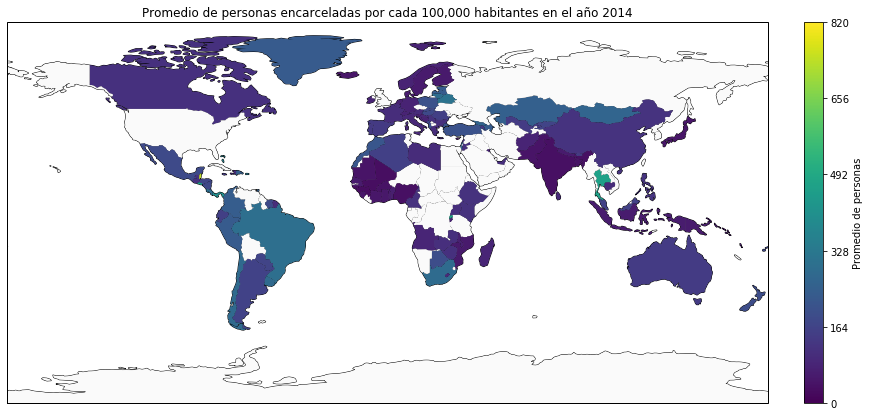

In [9]:
main()
#plt.savefig("Graficas_actividad2/Mapa_2014.png")

#### Pregunta 5

5. ¿Cómo se posiciona México en este aspecto respecto al resto del mundo?

Para poder visualizar esto, graficamos a México a la vez que el promedio mundial.

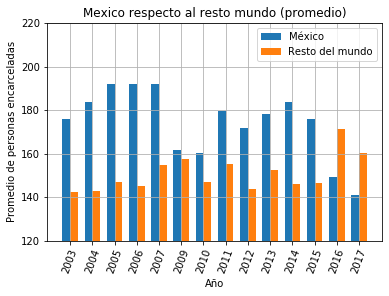

<Figure size 432x288 with 0 Axes>

In [42]:
labels = [2003, 2004, 2005, 2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
mexico = datos[datos.Countries=="Mexico"].sort_values(by = "Year")["Rate"]
x_this = []

for i in range(5):
    x_this.append(x_rate[i])
for i in range(9):
    x_this.append(x_rate[i+6])
    
x = np.arange(len(mexico))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x-width/2, mexico, width, label = "México")
rects2 = ax.bar(x+width/2, x_this, width, label = "Resto del mundo")

ax.set_ylabel("Promedio de personas encarceladas")
ax.set_title("Mexico respecto al resto mundo (promedio)")
ax.set_xticks(x)
ax.set_xlabel("Año")
ax.set_xticklabels(labels, rotation=70)
ax.legend()
ax.set_ylim(120, 220)


plt.grid()
plt.show()

plt.savefig("Graficas_actividad2/Mexico_vs_mundo.png")

#### Pregunta 6

6. ¿En que subregion se encuentra el mayor promedio de personas en situación de carcel?

Para poder contestar esta pregunta, se realizó un diagrama pastel

In [33]:
datos = datos.set_index(["Region", "Sub Region"])
datos = datos.sum(level = 0)
datos

,Year,Count,Rate
Region,,,
Asia,1037204,47254087.89,81872.932698
Europe,1364877,22543041.00,95143.688080
Africa,882595,9526984.00,55007.149249
Oceania,323657,585604.00,28067.493271
Americas,1043296,48999922.44,151305.947608


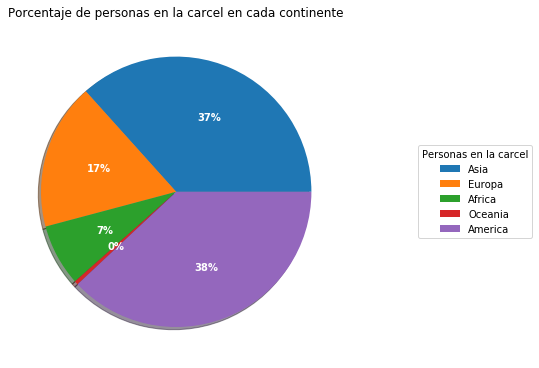

<Figure size 432x288 with 0 Axes>

In [34]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

labels = ["Asia", "Europa", "Africa", "Oceania", "America"]

wedges, texts, autotexts = ax.pie(datos.Count,
      autopct='%1.0f%%', shadow=True, textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="Personas en la carcel",
          loc="center left",
          bbox_to_anchor=(1.2, 0, 0.5, 1))

ax.set_title("Porcentaje de personas en la carcel en cada continente")
plt.setp(autotexts, size=10, weight="bold")
plt.show()

plt.savefig("Graficas_actividad2/Concentracion_continente.png")